### Метод Франка-Вульфа (Frank-Wolfe, метод условного градиента, conditional gradient)

Рассмотрим класс задач оптимизации следующего вида:

\begin{gather}
\underset{x}{\text{min}} & f(x) \\
\text{s.t.} & x \in D
\end{gather}
где $f$ - непрырыно дифференцируемая функция, $D \subset \mathbb{R}^n$ - __компактное__ (ограниченное, замкнутое) выпуклое множество.


После инициализации $x_0 \in D$ итерация $k$ метода Франка-Вульфа состоит из следующих шагов:

1. Найти $s_k = \arg\min_{x \in D} g^Tx$, где $g = \nabla f(x_k)$

2. Найти $\alpha_k = \frac{2}{k+2}$ или $\alpha_k = \arg\min_{\alpha} f(x_k + \alpha(s_k - x_k))$

3. Обновить $x_{k+1} = x_k + \alpha_k(s_k - x_k)$

На рисунке проиллюстрирована идея алгоритма: для текущего решения $x_k$ строится линейная аппроксимация $h(x) = f(x_k) + \nabla f(x_k)^T(x - x_k)$ целевой функции, а затем она минимизируется на $D$.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Frank-Wolfe_Algorithm.png/1280px-Frank-Wolfe_Algorithm.png" width=600>

Поскольку $h(x) \leq f(x)$ разницу $d = f(x_k) - \min_{x\in D}h(x) = \max_{x\in D}\nabla f(x_k)^T(x_k - x) = \nabla f(x_k)^T(x_k - s_k)$ можно использовать для определения критерия остановки алгоритма: $d < \varepsilon$.

http://www.maths.ed.ac.uk/~prichtar/Optimization_and_Big_Data_2015/slides/Jaggi.pdf

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import norm
import matplotlib.pyplot as plt

In [31]:
from scipy.optimize import line_search, minimize_scalar

def within_bounds(a, *args): return 0 <= a and a <= 1

def minimize_FW(func, x0, grad, LMO, max_iter=5000):
    x = x0.copy()
    k=0
    gradient = grad(x)
    s = LMO(gradient)
    d = np.sum(gradient*(x - s))
    while d > 1e-4 and k<max_iter:
        gradient = grad(x)
        s = LMO(gradient) # linear minimization oracle
        d = np.sum(gradient*(x - s)) 
        p = s - x # search direction
        alpha=None
        #alpha = minimize_scalar(lambda a: func(x + a*p), bounds=(0, 1)).x 
        #alpha = line_search(func, grad, x, p, extra_condition=within_bounds)[0]
        if alpha==None:
            alpha = 2./(k+2) #standard stepsize
        x = x + alpha*p
        k = k+1
    return x   
    

Пример 1:

$$ \min_{\|X\|_* \leq \gamma} {\lVert R - X  \rVert}^2_F  $$

In [3]:
import scipy.io

mat = scipy.io.loadmat('./data/ratings.mat')
R = np.array(mat['R'].todense())

m,n = R.shape

In [4]:
O = R > 0

def mc_objective(x, R, O): # YOUR CODE
    X = x.reshape(R.shape)
    return 0.5 * np.linalg.norm(R - np.multiply(X, O), 'fro')**2

def mc_gradient(x, R, O): # YOUR CODE
    X = x.reshape(R.shape)
    return (np.multiply(X, O) - R).flatten()

Шар ядерной нормы есть выпуклая оболочка одноранговых матриц:

$\{X\in \mathbb{R}^{m \times n}\ | \|X\|_* = \gamma \} = \{ uv^T| \|u\| = \|v\| = \gamma, u \in \mathbb{R}^m,  v \in \mathbb{R}^n \}$.

Поскольку минимум линейной функции на ограниченном множестве достигается на его границе, т.е. $X = uv^T$, то минимизация линейной функции $\mathrm{tr}(Y^TX)$ внутри шара ядерной нормы $\|X\|_* \leq \gamma$ эквивалентна задаче 

\begin{gather}
\underset{u,v}{\text{min}} & u^TYv \\
\text{s.t.} & \|u\| = \gamma \\
& \|v\| = \gamma \\
\end{gather}
поскольку $\mathrm{tr}(Y^Tuv^T) = u^TYv$.

Можно показать, что она имеет решение $X = -\gamma uv^T$, где $u$ и $v$ - левый и правый сингулярные вектора матрицы $Y$, соответствующие максимальному сингулярному числу ($u$ и $v$ могут быть эффективно найдены, например, с помощью [Power iteration](https://www.cs.cmu.edu/~venkatg/teaching/CStheory-infoage/book-chapter-4.pdf). См. функцию [svds](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html))

In [5]:

def power_method(A, num_steps=10):
    """Power method.
        
        Computes approximate top left and right singular vector.
        
    Parameters:
    -----------
        A : array {m, n},
            input matrix
        num_steps : integer, optional
            number of steps
            
    Returns:
    --------
        x, y : (m,), (n,)
            two arrays representing approximate top left and right
            singular vectors.
    """
    m, n = A.shape
    x = np.random.normal(0,1, m)
    x /= np.linalg.norm(x)
    y = A.T.dot(x)
    y /= np.linalg.norm(y)
    for _ in range(num_steps):      
        x = A.dot(y)
        x /= np.linalg.norm(x)
        y = A.T.dot(x)
        y /= np.linalg.norm(y)        
    return x, y

In [6]:
from scipy.sparse.linalg import svds

def nuclear_lmo(grad, gamma, shape=None):
    if not shape==None:
        u,s,vt = svds(-grad.reshape(shape), k=1)
        #u, vt = power_method(-grad.reshape(shape))
        return gamma*np.outer(u,vt).flatten()
    else:
        u,s,vt = svds(-grad, k=1)
        #u, vt = power_method(-grad)
        return gamma*np.outer(u,vt)

In [7]:
def rmse(X, R, O):
    n = np.count_nonzero(O)
    return np.sqrt(1./n*np.linalg.norm(R - np.multiply(X, O), 'fro')**2)

In [32]:
X0 = np.random.rand(m,n).flatten()*0.0001

f = lambda X: mc_objective(X, R, O)
fgrad = lambda X: mc_gradient(X, R, O)

gamma = 150
oracle = lambda x: nuclear_lmo(x, gamma, R.shape) 

x = minimize_FW(f, X0, fgrad, LMO=oracle)

X = x.reshape(R.shape)

In [33]:
R_test = np.array(mat['R_test'].todense())
O_test = R_test > 0

RMSE = rmse(X, R_test, O_test)

print(RMSE)

0.9384088876254644


Пример 2:

$$ \min_{\|x\|_1 \leq \gamma} f(x) $$

In [34]:
def f(x):
    return 0.5*(1-x[0])**2 + (x[1]-x[0]**2)**2

def fgrad(x):
    return np.array([-(1-x[0])-4*x[0]*(x[1]-x[0]**2), 2*(x[1] - x[0]**2)])

In [35]:
xx = np.arange(-1.5, 2, 0.01)
yy = np.arange(-1.5, 3, 0.01)
X,Y = np.meshgrid(xx, yy)

Z = 0.5*(1 - X)**2 + (Y - X**2)**2

In [36]:
def contoursteps(x1, x2, zs, steps=None):
    cp = plt.contour(x1, x2, zs, 50)
    plt.clabel(cp, inline=1, fontsize=10)
    if steps is not None:
        steps = np.matrix(steps)
        plt.plot(steps[:,0], steps[:,1], '-o')
        plt.plot(steps[-1,0], steps[-1,1], 'r-o')

Можно показать, что минимизация линейной функции $y^Tx$ внутри шара $l_1$-нормы $\|x\|_1 \leq \gamma$ имеет решение $x = -\gamma \mathrm{sign}(y_i)e_i$, где $i = \arg\max_i |y_i|$, а $e_i$ - $i$-й вектор стандартного базиса.

In [37]:
def l1_lmo(g, gamma):
    idx = np.argmax(np.abs(g))
    x = np.zeros(g.shape)
    x[idx] = -gamma*np.sign(g[idx])
    return x

In [38]:
x0 = np.array([-0.5, -0.5])

r = 1
oracle = lambda x: l1_lmo(x, gamma=r)

x = minimize_FW(f, x0, fgrad, LMO=oracle)

print(x)

[0.65298656 0.34697027]


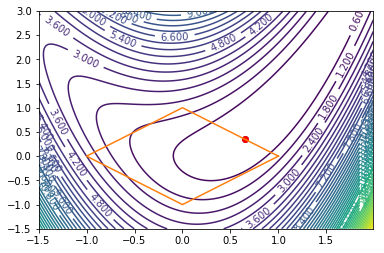

In [39]:
contoursteps(X,Y,Z,[x])

plt.plot([1, 0, -1, 0, 1], [0, 1, 0, -1, 0])
plt.show()